In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import os
from utils import *

tf.__version__ #2.10.0

#### load model

In [2]:
#CHOOSE MODEL

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import backend as K

if K.image_data_format() == 'channels_first':
    K.set_image_data_format('channels_last')
print(K.image_data_format())


channels_last


In [ ]:
model = ResNet50(include_top=True, weights='imagenet')
input_shape = model.layers[0].output_shape[0][1:3]
# model.summary()

### activation per layer

In [4]:
input_layer = model.layers[0]

#create outs for all layers
act_layers = [l for l in model.layers if 'Activation' in str(type(l)) or 'Dense'  in str(type(l))]
all_outs = K.function(inputs=[input_layer.input], 
                          outputs=[lact.output for lact in act_layers])

#### load flow samples

In [6]:
orig_shape = (800,600)
scl_factor = 0.5

mydirs = list(map(str,range(0,360,45)))
categories = ['grat_W12','grat_W1','grat_W2',
              'neg1dotflow_D1_bg','neg3dotflow_D1_bg','neg1dotflow_D2_bg','neg3dotflow_D2_bg',
              'pos1dotflow_D1_bg','pos3dotflow_D1_bg','pos1dotflow_D2_bg','pos3dotflow_D2_bg']

topdir = 'flowstims'
N_INSTANCES = 1
trial_len = 1# n frames
stride = 1
NDIRS = len(mydirs)
tot_stims = len(categories)*NDIRS
print('tot_stims',tot_stims,flush=True)
frames_per_stim = (trial_len//stride)
print('frames_per_stim',frames_per_stim)
flow_datasets = createFlowDataset(categories, topdir, mydirs, orig_shape, input_shape, scl_factor, N_INSTANCES, trial_len, stride)



tot_stims 88
frames_per_stim 1
*INSTANCE 0 ...........


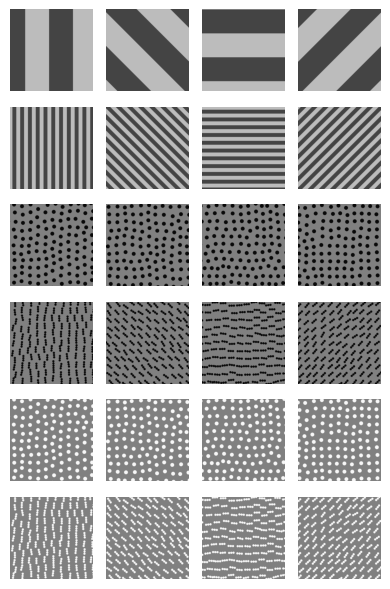

In [46]:
from deepnettools import subps
cats_to_show = [0,2,5,6,9,10]
f, axes = subps(len(cats_to_show), len(mydirs)//2, 1, 1)
for cati in range(len(cats_to_show)):
    for di in range(len(mydirs)//2):
        ax = axes[cati,di]
        cat = cats_to_show[cati]
        ax.imshow(flow_datasets[0][cat * len(mydirs) + di].reshape(input_shape), cmap='gray', vmin=0, vmax=255)
        ax.axis('off')
f.tight_layout()
plt.show()

In [38]:
dataset = np.concatenate([flow_datasets[ii] for ii in range(N_INSTANCES)],0)
def reshape_flow_img(raveled_1chan_img):
    return np.moveaxis(np.tile(raveled_1chan_img.reshape(input_shape),(3,1,1)),0,-1)
dataset = np.array([preprocess_input(reshape_flow_img(im)) \
     for im in dataset])
print(dataset.shape[0],'imgs')

#pass data through network
outs = all_outs([dataset])
for li in range(len(outs)):
    outs[li][outs[li] < 0] = 0
len(outs)

88 imgs


50

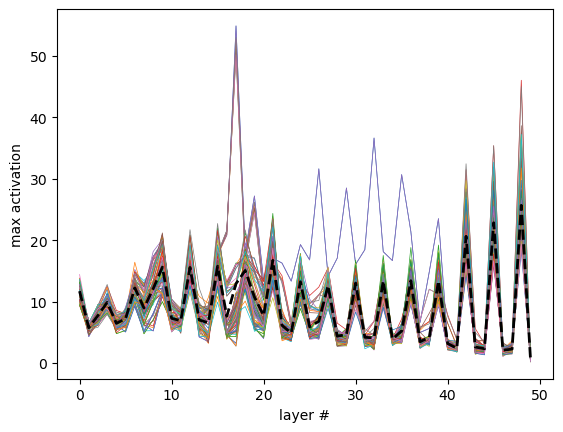

In [39]:
#1) pick an image
all_max_activations = []
for imi in range(dataset.shape[0]):
#2) for each layer, check max activation
    max_activations = np.array([outs[li][imi].max() for li in range(len(outs))])
    all_max_activations.append(max_activations)
    plt.plot(max_activations,lw=.5)
mean_max_flows = np.mean(all_max_activations,axis=0)
std_max_flows = np.std(all_max_activations,axis=0)
plt.plot(mean_max_flows,'k--',lw=2)

plt.xlabel('layer #')
plt.ylabel('max activation')
plt.show()

#### imgnet

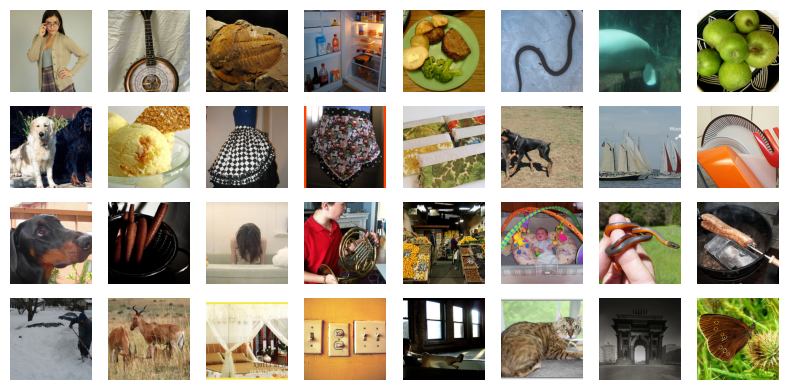

In [35]:
#random images from TEST SET 

sample_size = 88

#grab test set img filenames
folder_path = 'imgnet/ilsvrc2012/ILSVRC2012_img_test_v10102019/test'
all_imfnames = glob('%s/*.JPEG' % folder_path)
    
np.random.seed(0)
imis = np.random.choice(range(len(all_imfnames)),sample_size,False)
imfnames = [all_imfnames[imi] for imi in imis]


orig_shp = input_shape #W, H
pad = (0,0) #i, j
imshape = (orig_shp[1]-2*pad[0], orig_shp[0]-2*pad[1])
assert K.image_data_format() == 'channels_last'
imgX = np.zeros((sample_size,imshape[0],imshape[1],3),dtype='float32')

# show first 16 imgs from the sample
nrows = 4
ncols = 8
f, axes = subps(nrows, ncols, 1, 1)

for ii,imfname in enumerate(imfnames):
    
    im = Image.open(imfname)
    w, h = im.size
    
    #cropping to 224 x 224 (take into account original aspect ratio for best results)
    if w < h:
        resize_shp = (imshape[0],h*imshape[0]//w)
        crop = (resize_shp[1]-imshape[1])//2
        imarray = np.array(
            im.resize(resize_shp,Image.Resampling.LANCZOS))[crop:crop+imshape[0]]
    else:
        resize_shp = (w*imshape[1]//h,imshape[1])
        crop = (resize_shp[0]-imshape[0])//2
        imarray = np.array(
            im.resize(resize_shp,Image.Resampling.LANCZOS))[:,crop:crop+imshape[1]]
    if imarray.ndim == 2:
        imarray = np.stack([imarray]*3,2)
    
    imarray = imarray[pad[0]:pad[0]+imshape[0], pad[1]:pad[1]+imshape[1]]
    if ii < nrows*ncols:
        ax = axes.ravel()[ii]
        ax.imshow(imarray)
        ax.axis('off')
    imgX[ii] = preprocess_input(imarray)
    
f.tight_layout()
plt.show()

In [36]:
dataset = imgX
outs = all_outs([dataset])
#pass data through network
for li in range(len(outs)):
    outs[li][outs[li] < 0] = 0
len(outs)
len(outs)

50

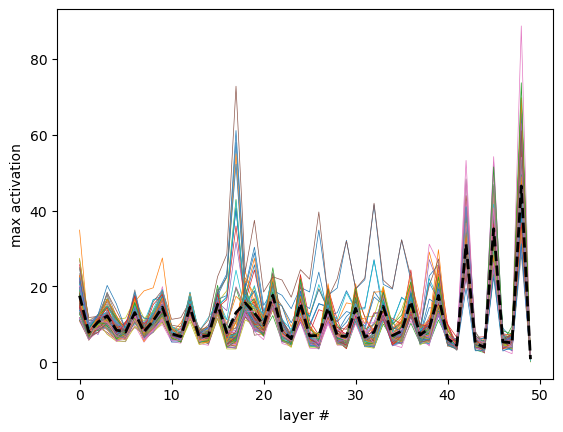

In [37]:
all_max_activations = []
#1) pick an image
for imi in range(dataset.shape[0]):
#2) for each layer, check max activation
    max_activations = np.array([outs[li][imi].max() for li in range(len(outs))])
    all_max_activations.append(max_activations)
    plt.plot(max_activations,lw=.5)
mean_max_imgnet = np.mean(all_max_activations,axis=0)
std_max_imgnet = np.std(all_max_activations,axis=0)
plt.plot(mean_max_imgnet,'k--',lw=2)
plt.xlabel('layer #')
plt.ylabel('max activation')
plt.show()


#### comparison

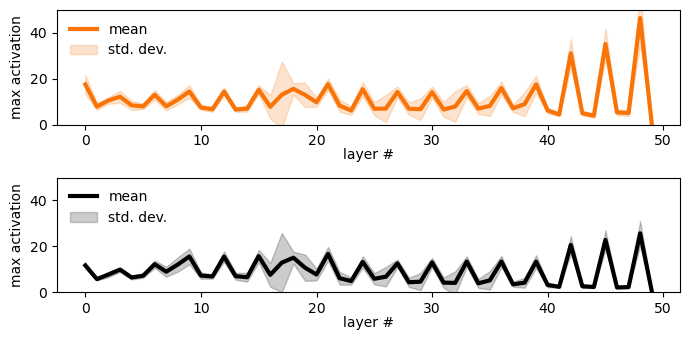

In [32]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

ylim = (0,50)
f,axes = plt.subplots(2,1,figsize=(7,3.5))
ax =axes[0]
x = range(len(mean_max_imgnet))
y = mean_max_imgnet
y_err = std_max_imgnet
c = 'xkcd:orange'
ax.plot(mean_max_imgnet,c=c,ls='-',lw=3.,label='mean')

ax.fill_between(x, y - y_err, y + y_err, color=c, alpha=0.2, label='std. dev.')
ax.set(ylabel='max activation',ylim=ylim)
ax.set_xlabel('layer #',labelpad=0)
ax.legend(framealpha=0)

ax = axes[1]
x = range(len(mean_max_flows))
y = mean_max_flows
y_err = std_max_flows
c = 'xkcd:black'
ax.plot(mean_max_flows,c=c,ls='-',lw=3.,label='mean')

ax.fill_between(x, y - y_err, y + y_err, color=c, alpha=0.2, label='std. dev.')
ax.set(ylabel='max activation',ylim=ylim)
ax.set_xlabel('layer #',labelpad=0)
ax.legend(framealpha=0,loc='upper left')
f.tight_layout()
plt.show()

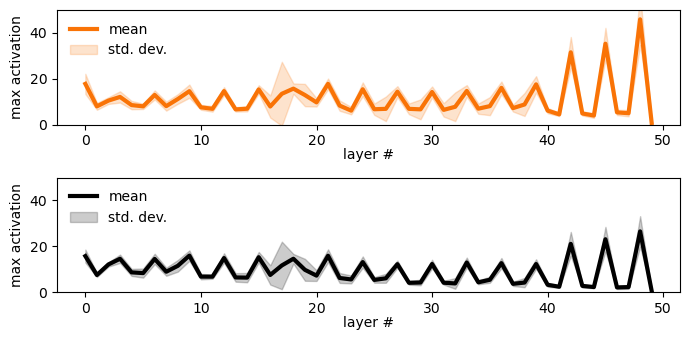

In [48]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

ylim = (0,50)
f,axes = plt.subplots(2,1,figsize=(7,3.5))
ax =axes[0]
x = range(len(mean_max_imgnet))
y = mean_max_imgnet
y_err = std_max_imgnet
c = 'xkcd:orange'
ax.plot(mean_max_imgnet,c=c,ls='-',lw=3.,label='mean')

ax.fill_between(x, y - y_err, y + y_err, color=c, alpha=0.2, label='std. dev.')
ax.set(ylabel='max activation',ylim=ylim)
ax.set_xlabel('layer #',labelpad=0)
ax.legend(framealpha=0)

ax = axes[1]
x = range(len(mean_max_flows))
y = mean_max_flows
y_err = std_max_flows
c = 'xkcd:black'
ax.plot(mean_max_flows,c=c,ls='-',lw=3.,label='mean')

ax.fill_between(x, y - y_err, y + y_err, color=c, alpha=0.2, label='std. dev.')
ax.set(ylabel='max activation',ylim=ylim)
ax.set_xlabel('layer #',labelpad=0)
ax.legend(framealpha=0,loc='upper left')
f.tight_layout()
# plt.savefig('activations_res50_fc.pdf', transparent=True)
plt.show()